In [1]:
import numpy as np
import pandas as pd

import altair as alt
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable("mimetype")
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server")
alt.data_transformers.disable_max_rows()

import copy
import os
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

In [2]:
sap_sugar_df = pd.read_pickle('data/processed/stinson2019/norm_tables/sap_sugar_weekly_summary')

gdd_frthw = pd.read_pickle('data/processed/stinson2019/norm_tables/gdd_frthw')
closest_weather_stn = pd.read_pickle('data/processed/stinson2019/norm_tables/closest_weather_stn')
gdd_frthw = gdd_frthw.merge(closest_weather_stn.reset_index(), how = 'left', on= 'stn_id')
gdd_frthw = gdd_frthw.set_index('datetime')

full_weekly = pd.read_pickle('data/processed/stinson2019/full_weekly_summary')


In [3]:
location = pd.read_pickle('data/processed/stinson2019/norm_tables/location')
sap_sugar_df
location

,lat,lon,short_name,long_name,state_province
site,,,,,
DOF,43.733800,-72.249000,Dartmouth,Dartmouth Organic Farm,NH
QC,48.430919,-70.688456,Boris,Boris,QC
HF,42.531500,-72.189900,Harvard,Harvard Forest,MA
INDU,41.625400,-87.081100,Indiana Dunes,Indiana Dunes National Lakeshore,IN
SMM,38.235181,-79.657058,Southernmost,Southernmost Maple,VA
DR,37.010800,-82.676400,Divide Ridge,Divide Ridge,VA


In [24]:
full_sap = pd.DataFrame(columns = ['tap_id', 'date_from', 'date_to', 'weekly_sugarwt', 'weekly_sap', 'site', 'cum_GDD', 'cum_frthw', 'weekly_frthw', 'sap_binary'])
for site in sap_sugar_df.site.unique():
    sap_sugar_site = copy.copy(sap_sugar_df[sap_sugar_df.site==site])
    gdd_frthw_site = copy.copy(gdd_frthw[gdd_frthw.site==site])
    sap_sugar_site = sap_sugar_site.assign(cum_GDD = sap_sugar_site.loc[:,'date_to'].apply(lambda x: gdd_frthw_site.loc[x]['cumGDD']), # Add cumulative GDD column
                                           cum_frthw = sap_sugar_site.loc[:,'date_to'].apply(lambda x: gdd_frthw_site.loc[x]['frthw']))  # Add cumulative freeze-thaw cycles column
    sap_sugar_site.loc[:,'weekly_frthw'] = sap_sugar_site.loc[:,'cum_frthw'] - sap_sugar_site['date_from'].apply(lambda x: gdd_frthw_site.loc[x]['frthw'])  # Add total weekly freeze-thaw cycles column
    sap_sugar_site['sap_binary'] = sap_sugar_site['weekly_sap'].map(lambda x: 0 if ((pd.isnull(x)) | (x==0)) else 1)  # Add column indicating if there was any sap flow in a given week
    full_sap = full_sap.append(sap_sugar_site)                    
       

In [23]:
full_sap[full_sap.site=='SMM']==sap_sugar_site

,tap_id,date_from,date_to,weekly_sugarwt,weekly_sap,site,cum_GDD,cum_frthw,weekly_frthw,sap_binary
19987,True,True,True,True,True,True,True,True,True,True
19988,True,True,True,True,True,True,True,True,True,True
19989,True,True,True,True,True,True,True,True,True,True
19990,True,True,True,True,True,True,True,True,True,True
19991,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
21570,True,True,True,True,True,True,True,True,True,True
21571,True,True,True,True,True,True,True,True,True,True
21572,True,True,True,True,True,True,True,True,True,True
21573,True,True,True,True,True,True,True,True,True,True


In their analysis, Houle et al. (2015) created a logistic regression model to predict the presence or absence of maple syrup production in a given week.  The following linear function was developed based on their measured data (note: signs have been reversed:

$$ P = -5.09 + 0.722F - 0.014F^2 - 0.07G$$

Where:

$P$ = Predictor of whether there will or will not be sap flowing in a given week (variable is labelled 'Production' in Houle et al., 2015)

$F$ = Cumulative number of freeze/thaw events in a given week (day of interest +/- 3 days).  A freeze/thaw event is counted if the temperature rises above a given threshold ($T_{thresh}$) and drops below it again.  A threshold of 3&deg;C has been used as in Houle et al., 2015.

$G$ = Cumulative number of growing degree days since the beginning of the year (January 1st) using a 5&deg;C base temperature ($T_{base}$).  Each day, the maximum air temperature ($T_{max}$is extracted and, if it is above the $T_{base}$, a value of $T_{base} - T_{max}$ is added to the running total of growing degree days ($G$).

Passing $P$ into a sigmoid function and applying a threshold of 0.51, we end up with a prediction of whether there will or will not be sap flow in a given week.

$$\hat{Y} = \begin{cases}
1 & \text{if} \ \frac{1}{1+e^{-P}} \geq 0.51 \\
0 & \text{if} \ \frac{1}{1+e^{-P}} < 0.51
\end{cases}
$$


In [25]:
# Coefficients of linear model created by Houle 2015
houle_coeff = np.array([-5.09, 0.733, -0.014, -0.07])
houle_thresh = 0.51    

# Create dataframe of parameters required for Houle 2015 analysis
houle2015 = full_sap[['site', 'tap_id', 'date_from', 'date_to', 'weekly_frthw', 'cum_GDD', 'sap_binary']]
houle2015 = houle2015.rename(columns={'weekly_frthw':'F', 'cum_GDD':'G', 'sap_binary':'Y'})


# Add F**2 column
houle2015['F2'] = houle2015.F**2



# Add bias column
houle2015['bias'] = 1
houle2015.loc[:,'P'] = houle2015[['bias', 'F', 'F2', 'G']]@(houle_coeff) 
houle2015.loc[:,'S'] = 1/(1 + np.exp(-houle2015['P']))  # Add intermediate sigmoid output column 'S'
houle2015.loc[:,'Y_hat'] = (houle2015['S'] > houle_thresh).astype(int) # Threshold determined by Houle 2015


In [31]:
houle2015['jd'] = (houle2015['date_from'].dt.dayofyear+houle2015['date_to'].dt.dayofyear)

In [32]:
houle2015

,site,tap_id,date_from,date_to,F,G,Y,F2,bias,P,S,Y_hat,jd
0,DOF,DOF1A,2014-03-05,2014-03-11,3.5,1.956098,1,12.25,1,-2.832927,0.055571,0,134
1,DOF,DOF1A,2014-03-06,2014-03-12,4.0,1.956098,1,16.00,1,-2.518927,0.074542,0,136
2,DOF,DOF1A,2014-03-07,2014-03-13,3.0,1.956098,1,9.00,1,-3.153927,0.040937,0,138
3,DOF,DOF1A,2014-03-08,2014-03-14,2.0,1.956098,1,4.00,1,-3.816927,0.021522,0,140
4,DOF,DOF1A,2014-03-09,2014-03-15,2.5,1.956098,1,6.25,1,-3.481927,0.029831,0,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21570,SMM,SMAS8B,2016-02-27,2016-03-04,1.0,22.598669,1,1.00,1,-5.952907,0.002592,0,122
21571,SMM,SMAS8B,2016-02-28,2016-03-05,2.0,22.598669,1,4.00,1,-5.261907,0.005159,0,124
21572,SMM,SMAS8B,2016-02-29,2016-03-06,3.5,22.598669,1,12.25,1,-4.277907,0.013682,0,126
21573,SMM,SMAS8B,2016-03-01,2016-03-07,4.0,22.598669,1,16.00,1,-3.963907,0.018635,0,128


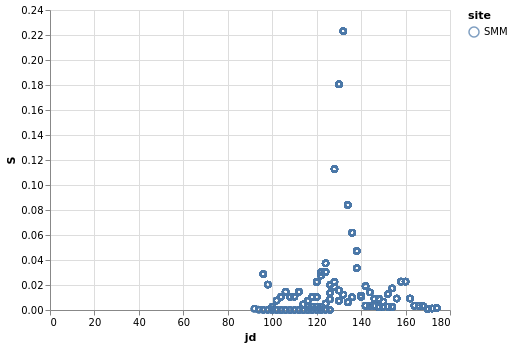

In [33]:
alt.Chart(houle2015[houle2015.site=='SMM']).mark_point().encode(x = 'jd', y = 'S', color = 'site')

In [36]:
houle2015.Y.value_counts()[1]/(houle2015.Y.value_counts()[1]+houle2015.Y.value_counts()[0])

0.9357682619647355

In [28]:
houle2015[houle2015.site=='SMM'].Y.value_counts()

1    1486
0     102
Name: Y, dtype: int64

In [29]:
houle2015[houle2015.site=='SMM'].Y_hat.value_counts()

0    1588
Name: Y_hat, dtype: int64

In [3]:
full_df = copy.copy(sap_sugar_df)
full_df = full_df.assign(cum_GDD = full_df.loc[:,'date_to'].apply(lambda x: gdd_frthw.loc[x]['cumGDD']),
                         weekly_frthw = full_df.loc[:,'date_to'].apply(lambda x: gdd_frthw.loc[x]['frthw']))
full_df.loc[:,'weekly_frthw'] -= full_df['date_from'].apply(lambda x: gdd_frthw.loc[x]['frthw'])

full_df['sap_binary'] = full_df['weekly_sap'].map(lambda x: 0 if ((pd.isnull(x)) | (x==0)) else 1)

full_df = full_df.assign(weekly_frthw_sq = lambda x: x.weekly_frthw**2,
                         houle_production = np.nan,
                         houle_sap_production = np.nan,
                         houle_binary = np.nan)

# Add columns related to model by Houle 2015
houle_coeff = np.array([-5.09, 0.733, -0.014, -0.07]) # Coefficients found by Houle 2015
full_df['ones'] = 1
full_df.loc[:,'houle_production'] = full_df[['ones', 'weekly_frthw', 'weekly_frthw_sq', 'cum_GDD']]@(-houle_coeff)
full_df.loc[:,'houle_production_sig'] = 1/(1 + np.exp(-full_df['houle_production']))
full_df.loc[:,'houle_binary'] = full_df['houle_sap_production'] > 0.51 # Threshold determined by Houle 2015

full_df

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [4]:
houle_coeff = np.array([-5.09, 0.733, -0.014, -0.07]) # Coefficients found by Houle 2015
full_df['ones'] = 1
full_df.loc[:,'houle_production'] = full_df[['ones', 'weekly_frthw', 'weekly_frthw_sq', 'cum_GDD']]@(-houle_coeff)
full_df.loc[:,'houle_production_sig'] = 1/(1 + np.exp(-full_df['houle_production']))
full_df.loc[:,'houle_binary'] = full_df['houle_production_sig'] > 0.51 # Threshold determined by Houle 2015

In [5]:
full_df

,date_from,date_to,weekly_sugarwt,weekly_sap,site,cum_GDD,weekly_frthw,sap_binary,weekly_frthw_sq,houle_production,houle_sap_production,houle_binary,ones,houle_production_sig
0,2014-03-11,2014-03-17,0.000543,0.04,DARTMOUTH ORGANIC FARM,4.870715,4.5,1,20.25,2.415950,NaN,True,1,0.918036
1,2014-03-12,2014-03-18,0.000183,0.01,DARTMOUTH ORGANIC FARM,4.870715,2.0,1,4.00,4.020950,NaN,True,1,0.982380
2,2014-03-13,2014-03-19,0.000183,0.01,DARTMOUTH ORGANIC FARM,4.870715,3.0,1,9.00,3.357950,NaN,True,1,0.966364
3,2014-03-14,2014-03-20,0.000183,0.01,DARTMOUTH ORGANIC FARM,4.870715,4.0,1,16.00,2.722950,NaN,True,1,0.938367
4,2014-03-15,2014-03-21,0.000183,0.01,DARTMOUTH ORGANIC FARM,4.870715,3.0,1,9.00,3.357950,NaN,True,1,0.966364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18278,2016-02-27,2016-03-04,0.731130,34.63,SOUTHERNMOST MAPLE,10.622917,5.0,1,25.00,2.518604,NaN,True,1,0.925436
18279,2016-02-28,2016-03-05,0.731130,34.63,SOUTHERNMOST MAPLE,10.622917,4.5,1,20.25,2.818604,NaN,True,1,0.943673
18280,2016-02-29,2016-03-06,0.720000,36.53,SOUTHERNMOST MAPLE,10.622917,5.5,1,30.25,2.225604,NaN,True,1,0.902525
18281,2016-03-01,2016-03-07,0.556020,27.42,SOUTHERNMOST MAPLE,10.622917,4.0,1,16.00,3.125604,NaN,True,1,0.957937


In [6]:
print(confusion_matrix(full_df['sap_binary'], full_df['houle_binary']))

[[    0  2240]
 [   95 15948]]


In [7]:
tn, fp, fn, tp = confusion_matrix(full_df['sap_binary'], full_df['houle_binary']).ravel()
(tn, fp, fn, tp)

(0, 2240, 95, 15948)

In [8]:
print(accuracy_score(full_df['sap_binary'], full_df['houle_binary']))

0.872285729913034


In [9]:
print(classification_report(full_df['sap_binary'], full_df['houle_binary']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2240
           1       0.88      0.99      0.93     16043

    accuracy                           0.87     18283
   macro avg       0.44      0.50      0.47     18283
weighted avg       0.77      0.87      0.82     18283



In [10]:
full_df.site.value_counts(normalize=True)

HARVARD FOREST             0.429743
DARTMOUTH ORGANIC FARM     0.246841
NORTHERN RANGE - QUEBEC    0.132363
INDU                       0.091943
SOUTHERNMOST MAPLE         0.063009
DIVIDE RIDGE               0.036099
Name: site, dtype: float64

In [11]:
X = full_df[['weekly_frthw','weekly_frthw_sq', 'cum_GDD']]
y = full_df['sap_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 123, stratify = full_df.site)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_train,y_train)


0.8776835771913032

In [12]:
print(logreg.intercept_, logreg.coef_)

[0.47552605] [[ 0.71497448 -0.06783927  0.00935915]]


In [13]:
# Test Houle parameters
logreg.intercept_ = [5.09]
logreg.coef_ = np.array([[-0.733, 0.014, 0.07]])
logreg.score(X_train,y_train)

0.8748119786681252

In [15]:
print(logreg.intercept_, logreg.coef_)

[5.09] [[-0.733  0.014  0.07 ]]


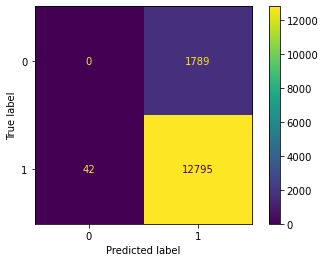

In [16]:
plot_confusion_matrix(logreg, X_train,y_train)

In [19]:
opt = {'--location':'all','--tree':'all', '--tap': 'all', '--years': 'all', '--species': 'ACSA'}

In [22]:
def add_ids(data):
    """Add unique record ids for each entry in sap dataframe

    Parameters
    ----------
    data : DataFrame
        Dataframe containing sap records

    Returns
    -------
    DataFrame
        Dataframe same as input but with new column containing a
        unique record id for each entry of the form:
        
        '<TreeID>_<TapID>_<RecordYear>_<ID#>'

        where ID# is 0 for the first record for a given tap in <RecordYear>, 
        1 is the second record of the year, etc.
    """
    
    id_df = data.sort_values(["site", "tree", "tap", "date"])

    # Create unique record ids for each entry in the following form:
    # "<TreeID>_<TapID>_<RecordYear>_<ID#>" where ID# is 0 for the first
    # record for a given tap in <RecordYear>, 1 is the second ...

    # First create "<TreeID>_<TapID>_<RecordYear>_" label for each record_id
    id_df["record_id"] = (
        +id_df["tree"]
        + "_"
        + id_df["tap"]
        + "_"
        + pd.DatetimeIndex(id_df["year"]).year.astype(str)
        + "_"
    )

    # Add "<ID#>" to each record_id
    for tapyear in id_df["record_id"].unique():
        id_df.loc[id_df["record_id"] == tapyear, "record_id"] += [
            str(i) for i in range(id_df[id_df["record_id"] == tapyear].shape[0])
        ]

    id_df["tap_id"] = id_df["tree"] + id_df["tap"]
    
    return id_df

In [23]:
def normalized_tables(data):
    """Create normalized tables from wide dataframe of sap measurements

    Parameters
    ----------
    data : DataFrame
        Wide dataframe of sap measurements

    Returns
    -------
    dict
        Dict of 7 normalized dataframes: tap_records, sap, sugar, dates, tap_tree, tree_species, site
    """
    df = {}

    df["tap_records"] = data[["record_id", "tap_id"]].set_index("record_id")
    df["sap"] = (
        data[["record_id", "sap_wt"]]
        .rename(columns={"sap_wt": "sap"})
        .set_index("record_id")
    )
    df["sugar"] = data[["record_id", "sugar"]].set_index("record_id")
    df["dates"] = data[["record_id", "date"]].set_index("record_id")
    df["dates"].loc[:, "date"] = pd.to_datetime(df["dates"]["date"])
    df["tap_tree"] = data[["tap_id", "tree"]].drop_duplicates().set_index("tap_id")
    df["tree_species"] = data[["tree", "species"]].drop_duplicates().set_index("tree")
    df["site"] = data[["tree", "site"]].drop_duplicates().set_index("tree")
    df["site"]["site"] = df['site']["site"].str.upper()

    return df

In [24]:

loc = opt['--location']
tre = opt['--tree']
tp = opt['--tap']
yrs = opt['--years']
spec = opt['--species']

processed_path = "../data/processed/stinson2019"

if not os.path.exists(processed_path):
    os.makedirs(processed_path)

# Load sap flow data
stinson2019 = pd.read_pickle(processed_path + "/stinson2019_df")

data = add_ids(stinson2019) # Add unique record id column to dataframe
normalized_data = normalized_tables(data) # Move data to normalized tables

In [84]:
import time

before = time.time()
# def get_weekly_data(normalized_data,location=["all"],tree="all", tap_id="all", years="all", species="ACSA",):
#     """Generate data table containing cumulative weekly sap and sugar amounts

#     Parameters
#     ----------
#     normalized_data : list
#         List of normalized dataframes from `normalized_tables` function.
#     location : str or list of str, optional
#         Name of locations (sites) to be included in data table, by default 'all'
#     tree : str or list of str, optional
#         ID of trees to be included in data table, by default 'all'
#     tap_id : str or list of str, optional
#         ID of taps to be included in data table, by default 'all'
#     years : int, list of ints, or 'all' , optional
#         Years to be included in data table, by default 'all'
#     species : str, list of str, or 'all' , optional
#         Species to be included in data table, by default 'ACSA' (sugar maple)

#     Returns
#     -------
#     pd.DataFrame
#         Table with weekly summaries for all taps specified in arguments.  Includes
#         cumulative sap and sugar weight, and weekly sap and sugar weight.
#     """
    
# Unpack normalized DataFrames
tap_records, sap, sugar, dates, tap_tree, tree_species, site = normalized_data.values()

location=loc
tree=tre
tap_id=tp
years=yrs
species=spec

# Check and clean location argument
if type(location) != list:
    location = [location]
location = [x.upper() for x in location]
if location == ["ALL"]:
    location = site["site"].unique().tolist()

# Check and clean tap_id argument
if type(tap_id) != list:
    tap_id = [tap_id]
tap_id = [x.upper() for x in tap_id]
if tap_id == ["ALL"]:
    tap_id = tap_tree.index.tolist()

# Check and clean tree argument
if type(tree) != list:
    tree = [tree]
tree = [x.upper() for x in tree]
if tree == ["ALL"]:
    tree = tap_tree["tree"].unique().tolist()

# Check and clean years argument
if type(years) != list:
    years = [years]
if type(years[0]) == str:
    years[0] = years[0].upper()
    if years == ["ALL"]:
        years = pd.DatetimeIndex(dates["date"]).year.unique().tolist()

# Check and clean species argument
if type(species) != list:
    species = [species]
species = [x.upper() for x in species]
if species == ["ALL"]:
    species = tree_species["species"].unique().tolist()

tap_id = (
    tap_tree[tap_tree.index.isin(tap_id)]
    .join(site, how="left", on="tree")
    .reset_index()
    .merge(tree_species, how="left", on="tree")
    .set_index("tap_id")
)
tap_id = tap_id[
    (tap_id["tree"].isin(tree))
    & (tap_id["site"].isin(location))
    & (tap_id["species"].isin(species))
].index.tolist()

# Initialize summary dataframe
weekly_df = pd.DataFrame()

# Create weekly summaries, iterating through all taps
for tap in tap_id:
    #         print("tap:  ", tap)
    # Create joint dataframe will all required info for current tap
    df = (
        tap_records.join(tap_tree[tap_tree.index == tap], how="right", on="tap_id")
        .join(sap, how="left")
        .join(sugar, how="left")
        .join(dates[pd.DatetimeIndex(dates["date"]).year.isin(years)], how="inner")
    )
    df["year"] = pd.DatetimeIndex(df["date"]).year
    df["jd"] = pd.DatetimeIndex(df["date"]).dayofyear

    for year in df["year"].unique():
        #             print('     year: ', year)
        df_year = df[df["year"] == year]

        # Deal with multiple entries per day.  Sap taken as sum of measurements, sugar content as weighted average.
        if not df_year["jd"].is_unique:
            df_year_temp = copy.copy(df_year)
            df_year_temp["product"] = df_year_temp.sap * df_year_temp.sugar.fillna(
                value=df_year_temp.sugar.mean()
            )
            df_year_temp = df_year_temp.groupby(by="jd").sum().reset_index()
            df_year_temp["sugar"] = df_year_temp["product"] / df_year_temp["sap"]
            df_year = df_year.drop_duplicates(subset="jd")
            df_year = (
                df_year.reset_index()
                .merge(
                    df_year_temp[["jd", "sap", "sugar"]],
                    on="jd",
                    how="right",
                    suffixes=["", "_sum"],
                )
                .set_index("record_id")
            )
            df_year["sap"] = df_year["sap_sum"]
            df_year["sugar"] = df_year["sugar_sum"]
            df_year = df_year.drop(columns=["sap_sum", "sugar_sum"])

        # Add entry for every day of year from first day with recorded flow to last
        df_year = (
            df_year.reset_index()
            .merge(
                pd.date_range(
                    start=df_year["date"].min(), end=df_year["date"].max()
                ).to_frame(name="date"),
                how="right",
                on="date",
            )
            .set_index("date", drop=False)
        )

        # Assumption: missing sugar content should be filled with mean sugar content
        df_year["sugarwt"] = (
            df_year.sap * df_year.sugar.fillna(value=df_year.sugar.mean()) / 100
        )

        # Assumption: missing sap values should be replaced with zeros
        df_year["cum_sap"] = df_year.sap.fillna(value=0).cumsum()
        df_year["cum_sugarwt"] = df_year.sugarwt.fillna(value=0).cumsum()
        df_year["tap_id"] = df_year.tap_id.fillna(value=tap)
        df_year["tree"] = df_year.tree.fillna(value=df_year.tree[0])
        df_year["year"] = pd.DatetimeIndex(df_year["date"]).year
        df_year["jd"] = pd.DatetimeIndex(df_year["date"]).dayofyear
        
        if df_year.shape[0] > 7:
            df_year['weekly_sap'] = df_year.loc[:,'cum_sap'].to_numpy() - np.concatenate((np.zeros(7), df_year.iloc[:-7]['cum_sap'].to_numpy()),axis=0)
            df_year['weekly_sugarwt'] = df_year.loc[:,'cum_sugarwt'].to_numpy() - np.concatenate((np.zeros(7), df_year.iloc[:-7]['cum_sugarwt'].to_numpy()),axis=0)
        else:
            df_year['weekly_sap'] = df_year['cum_sap']
            df_year['weekly_sugarwt'] = df_year['cum_sugarwt']
            
        df_year["cum_syrupLitres"] = df_year["cum_sugarwt"] / 1.33
        df_year["weekly_syrupLitres"] = df_year["weekly_sugarwt"] / 1.33
        

#         for day in df_year.index[6:]:
#             if df_year["date"].min() == (day - pd.to_timedelta(6, unit="D")):
#                 df_year.loc[day, "weekly_sap"] = df_year.loc[day]["cum_sap"]
#                 df_year.loc[day, "weekly_sugarwt"] = df_year.loc[day]["cum_sugarwt"]
#             else:
#                 df_year.loc[day, "weekly_sap"] = (
#                     df_year.loc[day]["cum_sap"]
#                     - df_year.loc[day - pd.to_timedelta(7, unit="D")]["cum_sap"]
#                 )
#                 df_year.loc[day, "weekly_sugarwt"] = (
#                     df_year.loc[day]["cum_sugarwt"]
#                     - df_year.loc[day - pd.to_timedelta(7, unit="D")]["cum_sugarwt"]
#                 )
#                 df_year.loc[day, "cum_syrupLitres"] = (
#                     df_year.loc[day, "cum_sugarwt"] / 1.33
#                 )
#                 df_year.loc[day, "weekly_syrupLitres"] = (
#                     df_year.loc[day, "weekly_sugarwt"] / 1.33
#                 )

        df_year["date_from"] = df_year["date"] - pd.to_timedelta(6, unit="D")
        df_year["date_to"] = df_year["date"]
        df_year["jd_from"] = df_year["jd"] - 6
        df_year["jd_to"] = df_year["jd"]
        df_year = df_year.drop(columns=["date", "jd", "record_id"])

        weekly_df = weekly_df.append(df_year[6:])

#     return weekly_df
print(before - time.time())

-8.17181134223938


In [82]:
np.concatenate((np.zeros(7), df_year.iloc[:-7]['cum_sap'].to_numpy()),axis=0)

array([0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# full_df = get_weekly_data(normalized_data, location=loc, tree=tre, tap_id=tp, years=yrs, species=spec) # Calculate weekly summary parameters
full_df = full_df.reset_index().merge(normalized_data['site'], on='tree', how='left')
sap_sugar_df = full_df.loc[:,['date_from', 'date_to', 'weekly_sugarwt', 'weekly_sap','site']]

full_df.to_pickle(processed_path + '/full_weekly_summary')
sap_sugar_df.to_pickle(processed_path + '/sap_sugar_weekly_summary')

In [100]:
location = pd.read_csv('../data/raw/stinson2019/ACERnet_LatLon.csv')
location = location.rename(columns = {'Site':'acronym', 'Loc':'loc'})
df__sites = stinson2019['site'].unique()
location['site'] = [df_sites[1], df_sites[3], df_sites[0], df_sites[5], df_sites[2], df_sites[4]]
location = location.set_index('site')
location

,acronym,short_name,long_name,loc,lat,lon
site,,,,,,
Dartmouth Organic Farm,DOF,Dartmouth,Dartmouth Organic Farm,NH,43.733800,-72.249000
Northern range - Quebec,QB,Boris,Boris,QB,48.430919,-70.688456
Harvard Forest,HF,Harvard,Harvard Forest,MA,42.531500,-72.189900
INDU,INDU,Indiana Dunes,Indiana Dunes National Lakeshore,IN,41.625400,-87.081100
Southernmost Maple,SMM,Southernmost,Southernmost Maple,VA,38.235181,-79.657058
Divide Ridge,DR,Divide Ridge,Divide Ridge,VA,37.010800,-82.676400


In [105]:
closest_weather_stn = pd.DataFrame({'stn_id': ['HF001']},index = location.index)
closest_weather_stn

,stn_id
site,
Dartmouth Organic Farm,HF001
Northern range - Quebec,HF001
Harvard Forest,HF001
INDU,HF001
Southernmost Maple,HF001
Divide Ridge,HF001


In [ ]:
#Dartmouth Organic Farm: Lebanon Municipal Airport -- ID: USW00094765v